## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
%matplotlib inline

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

In [3]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

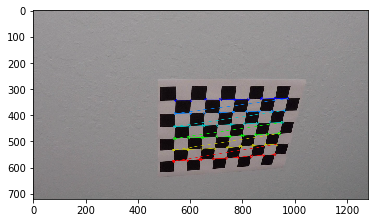

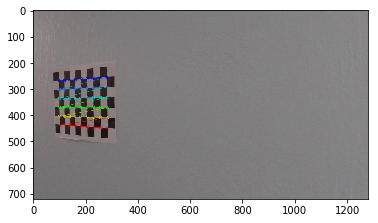

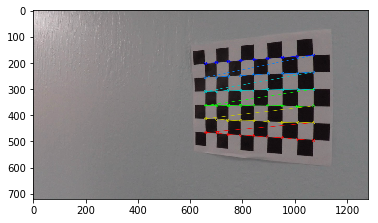

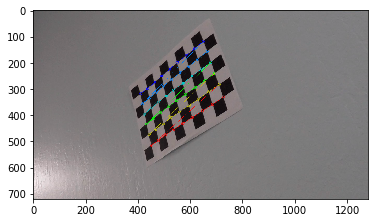

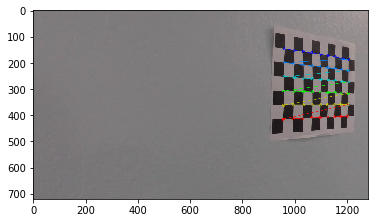

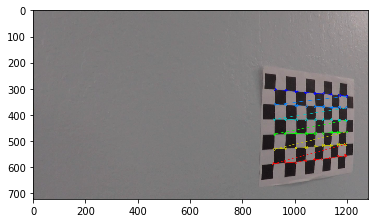

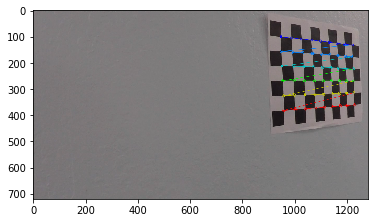

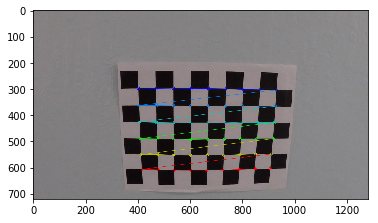

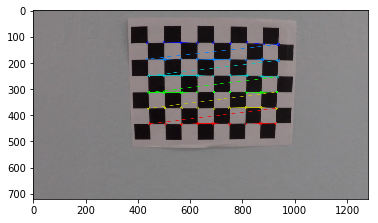

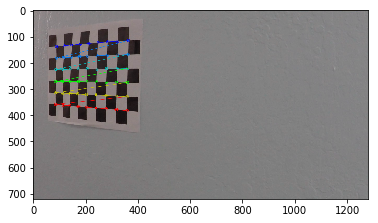

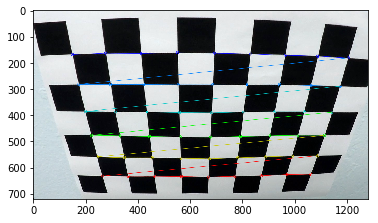

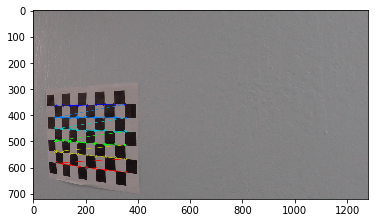

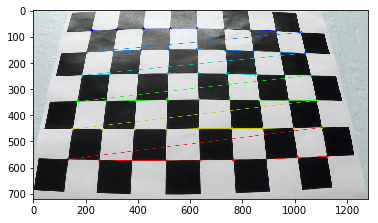

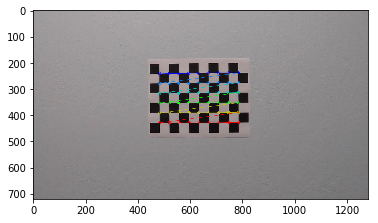

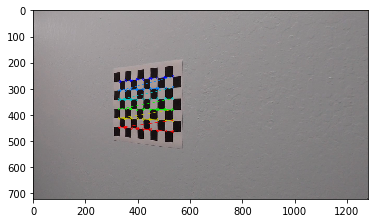

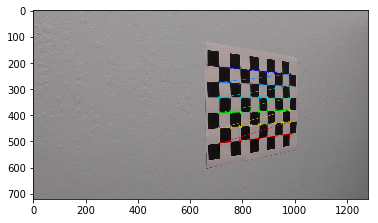

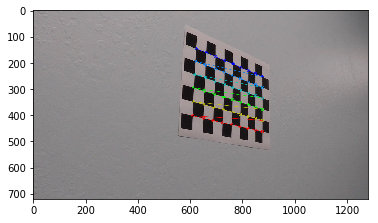

In [4]:
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()
        #cv2.waitKey(500)
#cv2.destroyAllWindows()

## And so on and so forth...

In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [6]:
# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    img = cv2.undistort(img, mtx, dist)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    # Find the chessboard corners
    ret, cn = cv2.findChessboardCorners(gray, (nx, ny), None)
    # 4) If corners found: 
    if ret == True:
            # a) draw corners
            cv2.drawChessboardCorners(img, (nx, ny), cn, ret)
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            src = np.float32([cn[0], cn[nx-1], cn[nx * (ny -1)], cn[(nx * ny) - 1]])
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            dst = np.float32([[100, 100],[1148,100],[100, 624],[1148, 624]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            M = cv2.getPerspectiveTransform(src, dst)
            img_size = (img.shape[1], img.shape[0])
            # e) use cv2.warpPerspective() to warp your image to a top-down view
            warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        plt.imshow(img)
        plt.show()
    #delete the next two lines
    #M = None
    #warped = np.copy(img) 
    return warped, M

In [7]:
img = cv2.imread('./camera_cal/calibration3.jpg')
warped_img, M = corners_unwarp(img, 9, 6, mtx, dist)

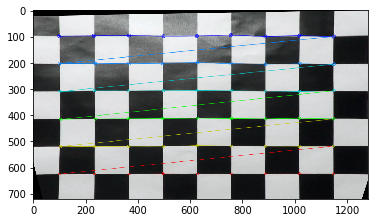

In [8]:
plt.imshow(warped_img)

[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] [[ -2.41017956e-01  -5.30721172e-02  -1.15810355e-03  -1.28318856e-04
    2.67125291e-02]]


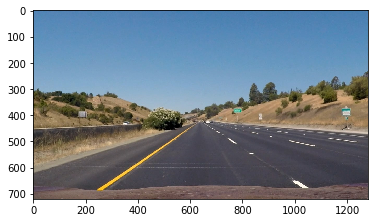

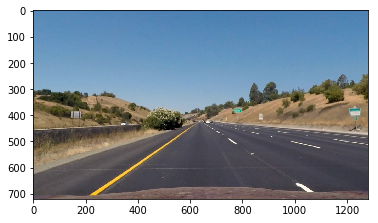

In [36]:

print(mtx, dist)
img = cv2.cvtColor(cv2.imread('./test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB) / 255.
img2 = cv2.undistort(img, mtx, dist)
plt.imshow(img)
plt.show()
plt.imshow(img2)
plt.show()

1.0


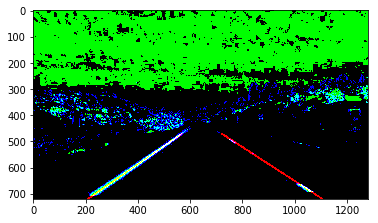

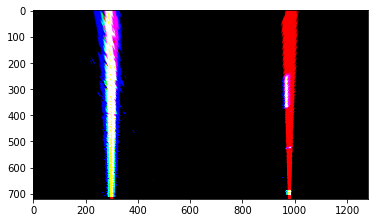

In [73]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:, :, 2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary_output

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color
    #print(vertices)
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

def get_src_pts(img):
    h, w = img.shape
    vert=[]
    #upper_left
    vert.append([w/2 -70, h/2 +110])
    #lower_left
    vert.append([210, h-1])
    #upper_right
    vert.append([w/2 +80, h/2 +110])
    #lower_right
    vert.append([w-175, h-1])
    return np.floor(vert).astype(int)

def get_dst_pts(img):
    h, w = img.shape
    vert=[]
    #upper_left
    vert.append([300, 0])
    #lower_left
    vert.append([300, h-1])
    #upper_right
    vert.append([w-300, 0])
    #lower_right
    vert.append([w-1-300, h-1])
    
    return np.floor(vert).astype(int)

def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #print('lines',len(lines))
    for i in range(len(lines)):
        #print(i)
        [x1,y1], [x2,y2] = lines[i]
        #print('line', lines[i])
        img = cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(100, 255), sx_thresh=(10, 255)): # s_thresh=(180, 255), sx_thresh=(25, 255)
    img2 = np.float32(np.copy(img))

    # Convert to HLS color
    hls = np.float32(cv2.cvtColor(img2, cv2.COLOR_RGB2HLS))
    s_channel = hls[:,:,2] * 255.
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    
    #bw_binary[(color_binary[:,:,2] == 1.) | (color_binary[:,:,1] == 5)] = 1
    lines_binary = np.zeros_like(s_binary)
    src = np.float32(get_src_pts(lines_binary))
    dst = np.float32(get_dst_pts(lines_binary))
    left_line = [src[0], src[1]]
    right_line = [src[2], src[3]]
    
    #print(src, dst)
    #print(lines_binary.shape)
    #print(s_binary.shape)
    
    # Convert scale to 0. - 1. from max of 255.
    lines_binary = draw_lines(lines_binary, [left_line,  right_line], thickness=5) / 255.
    
    color_binary = np.dstack((lines_binary, s_binary, sxbinary))
    plt.imshow(color_binary)
    plt.show()
    img_size = (color_binary.shape[1] ,  color_binary.shape[0])

    M = cv2.getPerspectiveTransform(src, dst)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(color_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped
print(np.max(img2))
warped = pipeline(img2)
plt.imshow(warped)


1.0


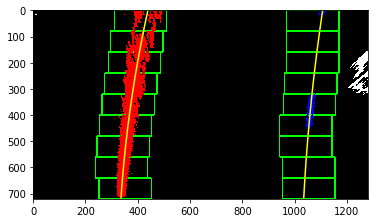

In [68]:
def find_lanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,1.,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1.,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.poly1d(np.polyfit(lefty, leftx, 2))
    right_fit = np.poly1d(np.polyfit(righty, rightx, 2))
    
    if True:
        # Generate y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1., 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1.]
        
        plt.imshow(out_img)
        plt.plot(left_fit(ploty), ploty, color='yellow')
        plt.plot(right_fit(ploty), ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        plt.show()
    
    return left_fit, right_fit

def get_lanes_binary(img):
    print(np.max(img))
    img_binary = np.zeros_like(img[:,:,0])
    img_binary[(img[:,:,1] == 1.) | (img[:,:,2] == 1.)] = 1.
    return img_binary
    
bw = find_lanes(get_lanes_binary(warped))
#plt.imshow(bw)
#plt.show()



In [56]:
from numpy.polynomial import Polynomial as P

def convert_to_meters(poly):
    #print(poly)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ys = np.linspace(0, 720, 10)
    xs = poly(ys)
    
    ys *= ym_per_pix
    xs *= xm_per_pix
    
    return np.poly1d(np.polyfit(ys, xs, 2))

def get_curve(poly, y_eval_meters=30):
    # Calculate the new radii of curvature
    # First derivative
    d = poly.deriv()
    # Second derivative
    d2 = d.deriv()
    #line_curverad = ((1 + (2*poly[0]*y_eval_meters + poly[1])**2)**1.5) / np.absolute(2*poly[0])
    line_curverad = ((1 + d(y_eval_meters)**2)**1.5) / np.absolute(d2(y_eval_meters))
    # Now our radius of curvature is in meters
    return line_curverad

def get_offset(lPoly, rPoly, y_eval_meters=30):
    x_left = lPoly(y_eval_meters)
    x_right = rPoly(y_eval_meters)
    #print(x_left, x_right)
    lane_center = (x_left + x_right) / 2.
    car_center = (1280 / 2.) * (3.7/700)
    return car_center - lane_center
    
    

------------
straight_lines1.jpg


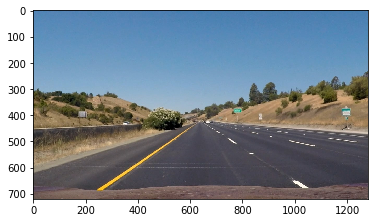

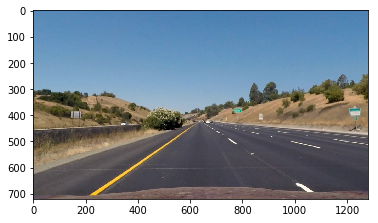

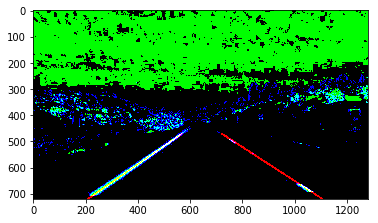

1.0


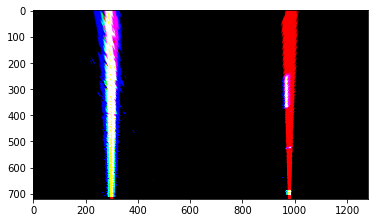

1.0


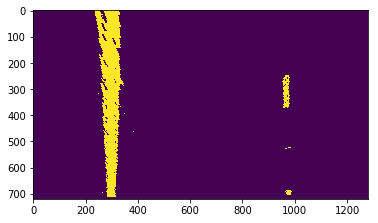

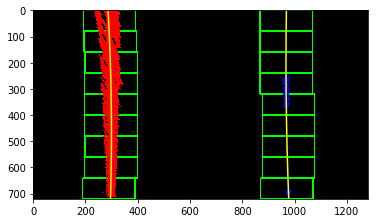

left 2.774050566179939 km | right 4.299976319548354 km | offset 1.755129714178194 cm
------------
straight_lines2.jpg


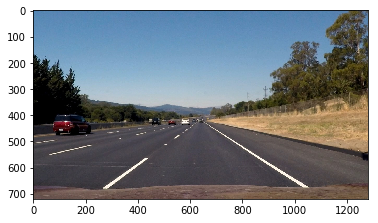

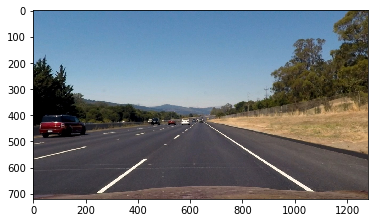

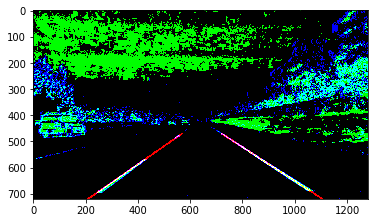

1.0


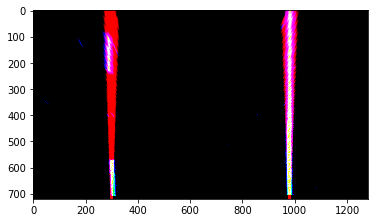

1.0


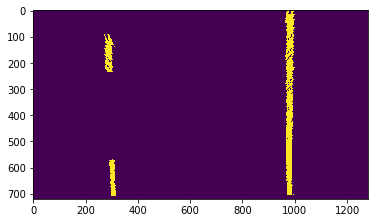

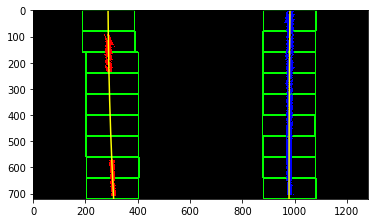

left 5.112517535965653 km | right 18.788048320064586 km | offset -1.7832608228610436 cm
------------
test1.jpg


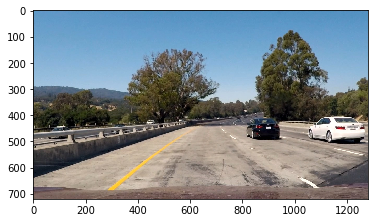

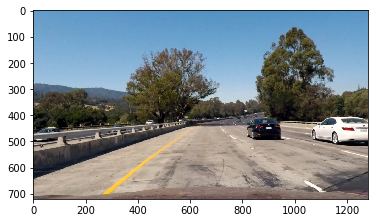

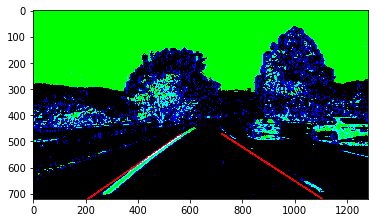

1.0


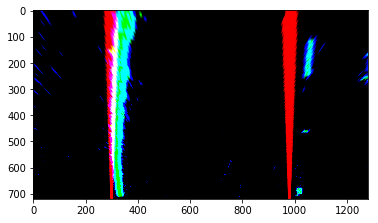

1.0


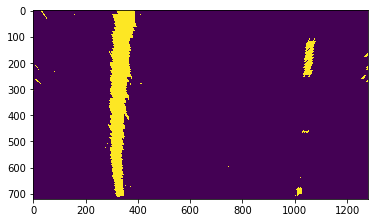

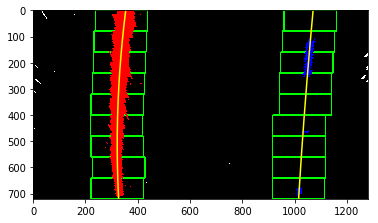

left 1.3349405668402128 km | right 7.09216561069875 km | offset -16.459108607658468 cm
------------
test2.jpg


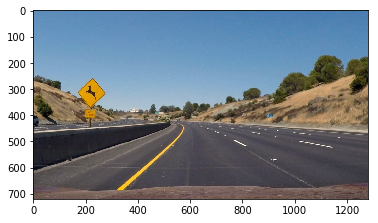

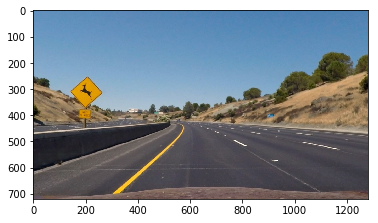

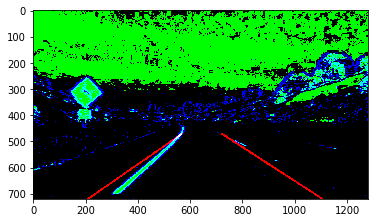

1.0


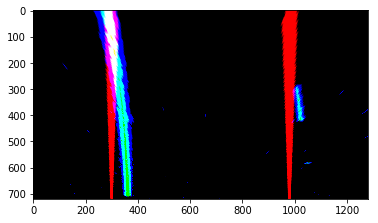

1.0


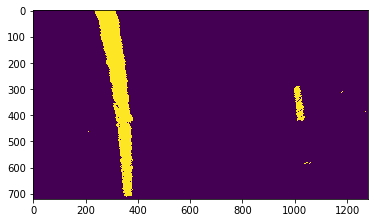

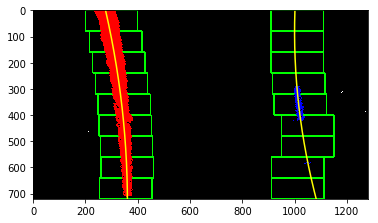

left 1.0611883788795284 km | right 0.8107802844008432 km | offset -43.06674358377367 cm
------------
test3.jpg


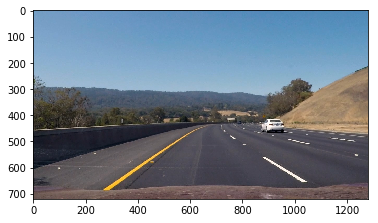

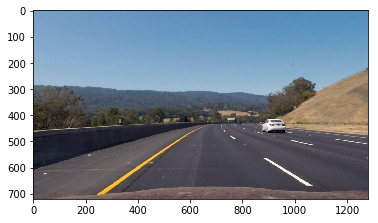

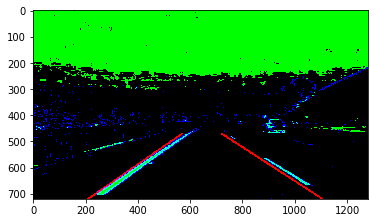

1.0


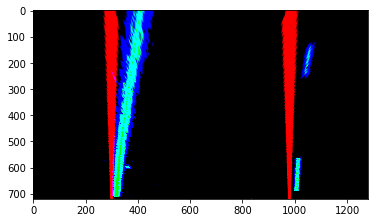

1.0


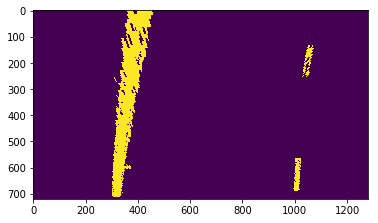

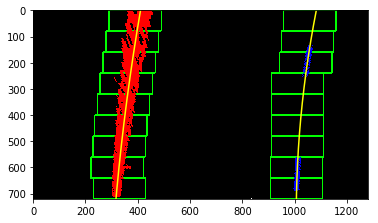

left 2.8472341296217487 km | right 1.3153633180102549 km | offset -11.563353866976334 cm
------------
test4.jpg


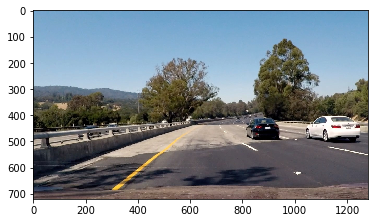

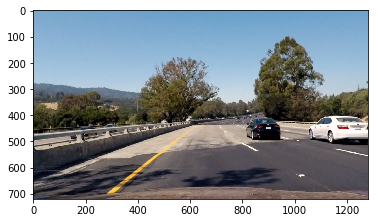

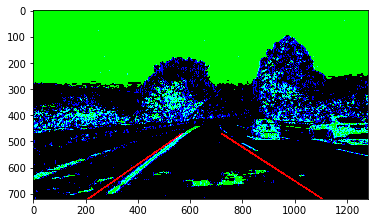

1.0


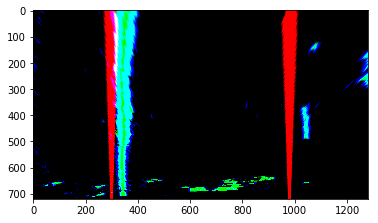

1.0


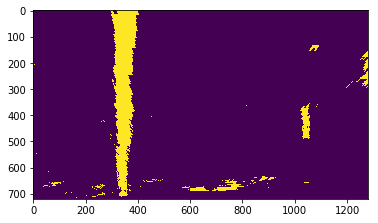

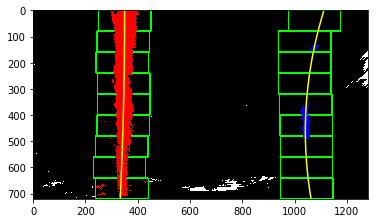

left 4.721524346214618 km | right 0.4969509722376374 km | offset -30.64165945737094 cm
------------
test5.jpg


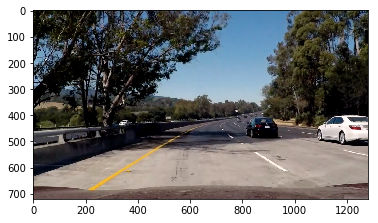

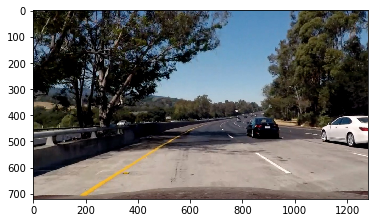

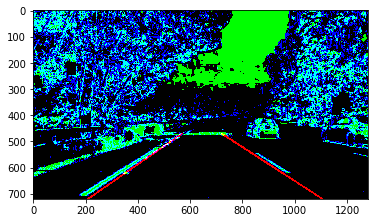

1.0


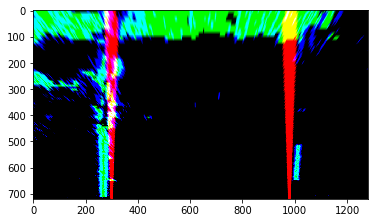

1.0


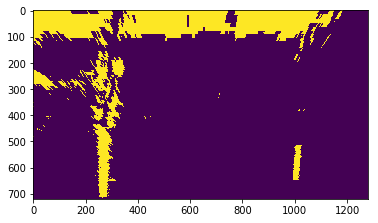

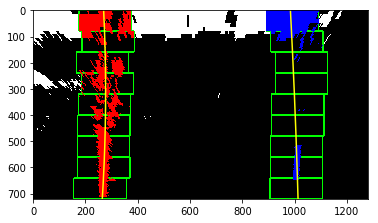

left 2.1369884232681575 km | right 9.641415312219975 km | offset 0.6344876434034141 cm
------------
test6.jpg


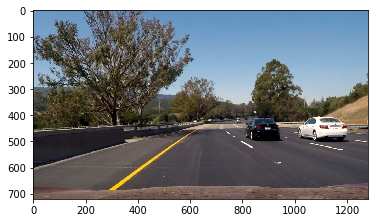

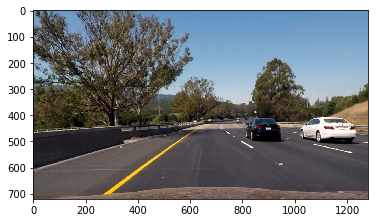

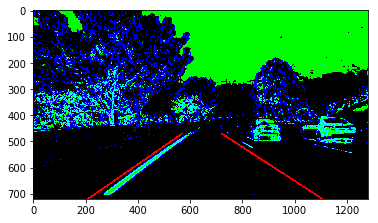

1.0


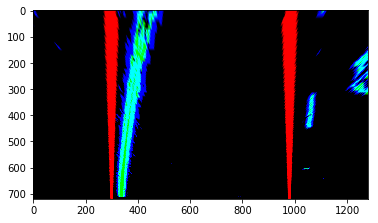

1.0


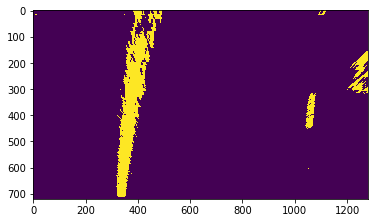

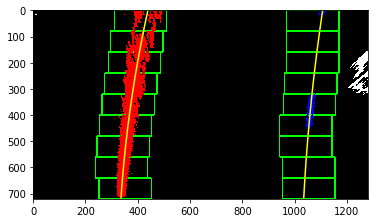

left 1.5363540530041648 km | right 2.464468588003943 km | offset -23.956212466848868 cm


In [69]:
import os

for f in os.listdir('./test_images'):
    print('------------')
    print(f)
    im = cv2.cvtColor(cv2.imread('./test_images/' + f), cv2.COLOR_BGR2RGB) / 255.
    plt.imshow(im)
    plt.show()
    im = cv2.undistort(im, mtx, dist)
    plt.imshow(im)
    plt.show()
    warped = pipeline(im)
    print(np.max(warped))
    plt.imshow(warped)
    plt.show()
    bw = get_lanes_binary(warped)
    plt.imshow(bw)
    plt.show()
    left_lane_p, right_lane_p = map(convert_to_meters, find_lanes(bw))

    print("left {} km | right {} km | offset {} cm".format(get_curve(left_lane_p) / 1000., get_curve(right_lane_p) / 1000., get_offset(left_lane_p, right_lane_p) * 100.))

    

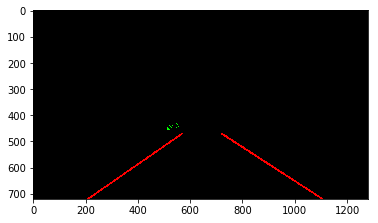

1.0


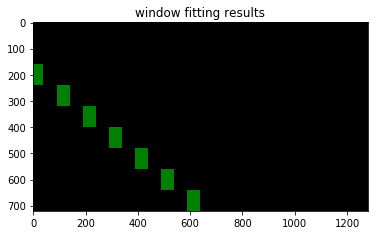

In [74]:
# Read in a thresholded image
img = mpimg.imread('./test_images/straight_lines1.jpg')
img = cv2.undistort(img, mtx, dist)
img = pipeline(img)
warped = get_lanes_binary(img) * 255.


# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width//2)):min(int(center+width//2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]//4):,:int(warped.shape[1]//2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]//4):,int(warped.shape[1]//2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width//2+int(warped.shape[1]//2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]//window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

warped *= 255.
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [76]:
# Import everything needed to edit/save/watch video clips
#import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

